In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

plt.style.use('bmh')
plt.rcParams["figure.dpi"] = 96
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_valorant = pd.read_csv('df_valorant.csv')
df_valorant.head()

,Unnamed: 0,index,eventId,seriesId,matchId,teamId,teamName,map,oppTeamId,oppTeamName,...,clutchOpponents,clutchOpportunities,KDR,KD,FKD,KDA,spentCreds,loadoutValue,avgEconRating,dates
0,476,477,566,14116,28923,279,LG,Icebox,2367,WS,...,7,3,1.878049,36,7,77.853659,2197.058824,4020.000000,70.929050,2021-07-01
1,319,319,566,14164,29066,4002,GOD,Ascent,978,GHST,...,44,12,0.513889,-35,-3,37.194444,2420.000000,2860.588235,35.094798,2021-07-01
2,318,318,566,14164,29066,978,GHST,Ascent,4002,GOD,...,13,4,1.945946,35,3,72.864865,2079.411765,3867.647059,69.765205,2021-07-01
3,317,317,566,14159,29052,3530,UNNAMED,Icebox,799,UNNAMED,...,7,4,1.810811,30,4,67.540541,2159.285714,3775.714286,73.661925,2021-07-01
4,316,316,566,14159,29052,799,UNNAMED,Icebox,3530,UNNAMED,...,40,13,0.552239,-30,-4,37.149254,2507.857143,3003.571429,40.074053,2021-07-01


In [3]:
df_valorant['dates'] = pd.to_datetime(df_valorant['dates'])
df_valorant.sort_values(by='dates', inplace=True)
df_valorant["day_code"] = df_valorant["dates"].dt.dayofweek
df_valorant = pd.get_dummies(df_valorant, prefix=['map'], columns=['map'] , dtype=np.int64)

In [4]:
df_valorant.columns

Index(['Unnamed: 0', 'index', 'eventId', 'seriesId', 'matchId', 'teamId',
       'teamName', 'oppTeamId', 'oppTeamName', 'teamScore', 'atkFirst', 'won',
       'acs', 'kills', 'firstKills', 'deaths', 'firstDeaths', 'assists',
       'damage', 'headshots', 'bodyshots', 'legshots', 'plants', 'defusals',
       'clutches', 'clutchOpponents', 'clutchOpportunities', 'KDR', 'KD',
       'FKD', 'KDA', 'spentCreds', 'loadoutValue', 'avgEconRating', 'dates',
       'day_code', 'map_Ascent', 'map_Bind', 'map_Breeze', 'map_Haven',
       'map_Icebox', 'map_Split'],
      dtype='object')

In [5]:
df_valorant = df_valorant[['dates', 'day_code', 'matchId', 'teamId', 'oppTeamId', 'teamScore', 'atkFirst', 
                           'won', 'acs', 'kills', 'firstKills', 'deaths', 'firstDeaths', 'assists', 'damage',
                           'headshots', 'bodyshots', 'legshots', 'plants', 'defusals', 'clutches','clutchOpponents', 
                           'clutchOpportunities', 'KDR', 'KD', 'FKD', 'KDA', 'spentCreds', 'loadoutValue', 
                           'avgEconRating', 'map_Ascent', 'map_Bind', 'map_Breeze', 'map_Haven', 'map_Icebox',
                           'map_Split']]

In [6]:
def rolling_avg(data, cols, new_cols):
    data = data.sort_values('dates')
    rolling_stats = data[cols].rolling(3, closed='left').mean()
    data[new_cols] = rolling_stats
    data = data.dropna(subset=new_cols)
    return data

In [7]:
df_valorant['teamId'].value_counts().tail(85)

1282    4
4420    3
4441    3
2414    3
4430    3
       ..
3337    2
3982    2
4427    2
3994    1
1436    1
Name: teamId, Length: 85, dtype: int64

In [8]:
cols = ['teamScore', 'acs', 'kills', 'firstKills', 'deaths', 'firstDeaths', 'assists', 'damage',
        'headshots', 'bodyshots', 'legshots', 'plants', 'defusals', 'clutches','clutchOpponents', 
        'clutchOpportunities', 'KDR', 'KD', 'FKD', 'KDA', 'spentCreds', 'loadoutValue','avgEconRating']

new_cols = [f"{c}_rolling" for c in cols]

In [9]:
df_teams_rolling = df_valorant.groupby('teamId').apply(lambda x: rolling_avg(x, cols, new_cols))

In [10]:
df_teams_rolling.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 837 entries, (63, 371) to (4442, 1026)
Data columns (total 59 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   dates                        837 non-null    datetime64[ns]
 1   day_code                     837 non-null    int64         
 2   matchId                      837 non-null    int64         
 3   teamId                       837 non-null    int64         
 4   oppTeamId                    837 non-null    int64         
 5   teamScore                    837 non-null    int64         
 6   atkFirst                     837 non-null    int64         
 7   won                          837 non-null    int64         
 8   acs                          837 non-null    float64       
 9   kills                        837 non-null    int64         
 10  firstKills                   837 non-null    int64         
 11  deaths                      

In [11]:
df_teams_rolling.drop(['teamId'], axis=1, inplace=True)
df_teams_rolling.sort_values(by='dates', inplace=True)
df_teams_rolling.reset_index(inplace=True)
df_teams_rolling.drop(['level_1'], axis=1, inplace=True)
#scaler = StandardScaler()

#df_teams_rolling.iloc[:,36:] = scaler.fit_transform(df_teams_rolling.iloc[:,36:])



In [12]:
train = df_teams_rolling[df_teams_rolling['dates'] < '2021-08-11']
test = df_teams_rolling[df_teams_rolling['dates'] >= '2021-08-11']

X_train = train[['atkFirst', 'map_Ascent', 'map_Bind', 'map_Breeze',
                  'map_Haven', 'map_Icebox', 'map_Split', 'teamScore_rolling',
                  'acs_rolling', 'kills_rolling', 'firstKills_rolling', 'deaths_rolling',
                  'firstDeaths_rolling', 'assists_rolling', 'damage_rolling',
                  'headshots_rolling', 'bodyshots_rolling', 'legshots_rolling',
                  'plants_rolling', 'defusals_rolling', 'clutches_rolling',
                  'clutchOpponents_rolling', 'clutchOpportunities_rolling', 'KDR_rolling',
                  'KD_rolling', 'FKD_rolling', 'KDA_rolling', 'spentCreds_rolling',
                  'loadoutValue_rolling', 'avgEconRating_rolling']]

y_train = train[['won']]

X_test = test[['atkFirst', 'map_Ascent', 'map_Bind', 'map_Breeze',
                'map_Haven', 'map_Icebox', 'map_Split', 'teamScore_rolling',
                'acs_rolling', 'kills_rolling', 'firstKills_rolling', 'deaths_rolling',
                'firstDeaths_rolling', 'assists_rolling', 'damage_rolling',
                'headshots_rolling', 'bodyshots_rolling', 'legshots_rolling',
                'plants_rolling', 'defusals_rolling', 'clutches_rolling',
                'clutchOpponents_rolling', 'clutchOpportunities_rolling', 'KDR_rolling',
                'KD_rolling', 'FKD_rolling', 'KDA_rolling', 'spentCreds_rolling',
                'loadoutValue_rolling', 'avgEconRating_rolling']]

y_test = test[['won']]

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(685, 30)
(685, 1)
(152, 30)
(152, 1)


In [14]:
clf=RandomForestClassifier(n_estimators=500, random_state = 18)

clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [15]:
f1_score(y_test, y_pred)

0.6178010471204188

In [16]:
def plot_feature_importances(df):
    df = df.sort_values('importance', ascending = False).reset_index()
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    plt.figure(figsize = (8, 5))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:30]))), 
            df['importance_normalized'].head(30), 
            align = 'center', edgecolor = 'k')
   
    ax.set_yticks(list(reversed(list(df.index[:30]))))
    ax.set_yticklabels(df['feature'].head(30))
    
    plt.xlabel('Importancia normalizada'); plt.title('Importancia de variables')
    plt.show();
    
    return df

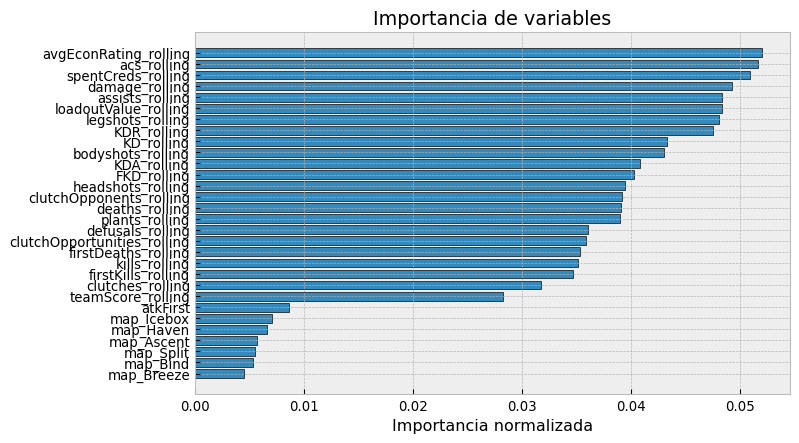

In [17]:
features = list(X_train.columns)

feature_importance_values = clf.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

feature_importances_sorted = plot_feature_importances(feature_importances)

In [18]:
n_estimators = [int(x) for x in range(200,2000,200)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [19]:
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_estimators=500,
                                                    random_state=18),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800]},
                   random_state=42, verbose=2)

In [20]:
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [21]:
rf_model = RandomForestClassifier(n_estimators = 1200, min_samples_split = 5, min_samples_leaf = 1, 
                                  max_features='auto', bootstrap=True, n_jobs=-1, max_depth = 10, 
                                  random_state = 32)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)

In [22]:
f1_score(y_test, y_pred)

0.6428571428571429

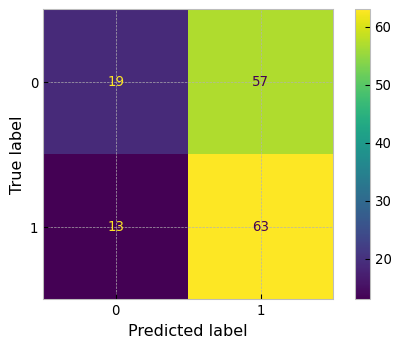

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()
plt.show();

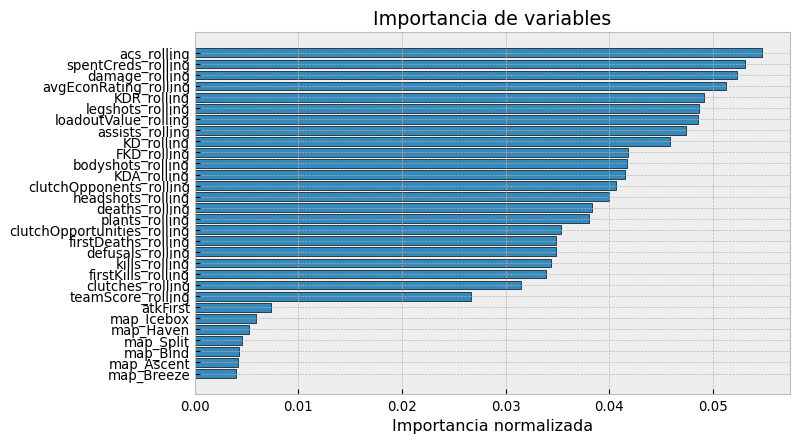

In [24]:
features = list(X_train.columns)

feature_importance_values = rf_model.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

feature_importances_sorted = plot_feature_importances(feature_importances)

In [25]:
XGB_model = XGBClassifier(random_state = 14)

XGB_model.fit(X_train, y_train)
y_pred = XGB_model.predict(X_test)

In [26]:
f1_score(y_test, y_pred)

0.56

In [27]:
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}

gs2 = GridSearchCV(XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs2.fit(X_train, y_train)

print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)

[11:46:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma" } are not used.

Best score: 0.5673776300637302
Best score: {'base_score': 0.2, 'booster': 'gblinear', 'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 500, 'reg_alpha': 0.5, 'reg_lambda': 5}


In [28]:
XGB_model = XGBClassifier(random_state = 15, base_score = 0.2, booster = 'gblinear', gama = 0,
                          learning_rate = 0.1, n_estimators = 500, reg_alpha = 0.5, reg_lambda = 5)

XGB_model.fit(X_train, y_train)
y_pred = XGB_model.predict(X_test)

[11:46:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gama" } are not used.



In [29]:
f1_score(y_test, y_pred)

0.6756756756756757

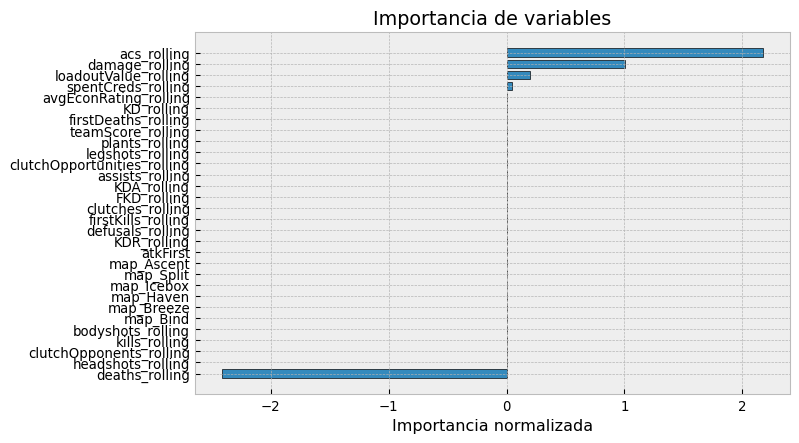

In [30]:
feature_importance_values = XGB_model.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

feature_importances_sorted = plot_feature_importances(feature_importances)

In [36]:
X_train = train[['acs_rolling', 'damage_rolling', 'deaths_rolling', 'headshots_rolling',
                 'loadoutValue_rolling', 'spentCreds_rolling', 'clutchOpponents_rolling']]

y_train = train[['won']]

X_test = test[['acs_rolling', 'damage_rolling', 'deaths_rolling', 'headshots_rolling',
               'loadoutValue_rolling', 'spentCreds_rolling', 'clutchOpponents_rolling']]

y_test = test[['won']]

In [37]:
XGB_model = XGBClassifier(random_state = 31, base_score = 0.2, booster = 'gblinear',
                          learning_rate = 0.1, n_estimators = 500, reg_alpha = 0.5, reg_lambda = 5)

XGB_model.fit(X_train, y_train)
y_pred = XGB_model.predict(X_test)

In [38]:
f1_score(y_test, y_pred)

0.6756756756756757

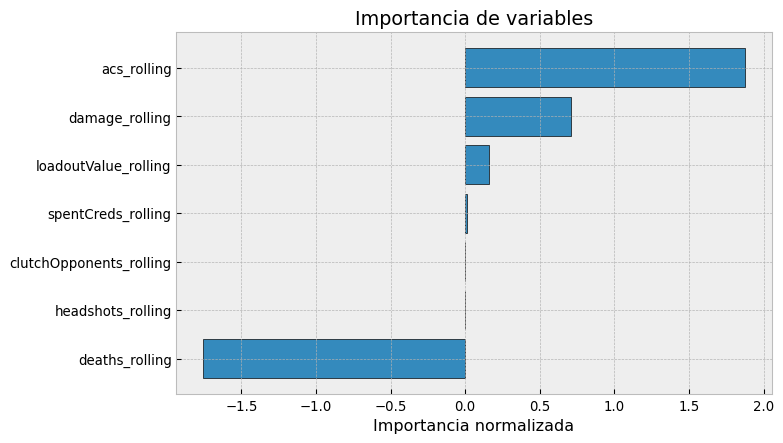

In [39]:
features = list(X_train.columns)

feature_importance_values = XGB_model.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

feature_importances_sorted = plot_feature_importances(feature_importances)